<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/Copy_of_benchmarkXAIdiabetesXGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install beexai

In [2]:
!git clone https://github.com/SquareResearchCenter-AI/BEExAI.git

Cloning into 'BEExAI'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 301 (delta 95), reused 244 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (301/301), 37.41 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [2]:
%cd BEExAI

/content/BEExAI


In [3]:
!pip install -r requirements.txt

In [4]:
import pandas as pd
Dataset = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
Dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [50]:
import yaml

# Define the configuration as a Python dictionary
config_data = {
    "path": "/content/drive/MyDrive/diabetes.csv",  # Corrected key with quotes
    "target_col": "Outcome",                       # Corrected key with quotes
    "cleaned_data_path": "/content/BEExAI/output/data/diabetes.csv",
    "task": "regression"
}

# Write the configuration to a YAML file
config_path = "/content/BEExAI/config/diabetes.yml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Config file saved successfully at {config_path}")

Config file saved successfully at /content/BEExAI/config/diabetes.yml


In [51]:
import sys
sys.path.append('/content/BEExAI/src')

In [52]:
from beexai.dataset.load_data import load_data

# Define the path to the configuration file
CONFIG_PATH = "config/diabetes.yml"

# Load the dataset, target column, and task type using the configuration file
data_test, target_col, task, _ = load_data(
    from_cleaned=False,
    config_path=CONFIG_PATH,
    keep_corr_features=True
)

# Display the loaded data, target column, and task type
print("Data Test Sample:")
print(data_test.head())

print("Target Column:", target_col)
print("Task:", task)

Data Test Sample:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Target Column: Outcome
Task: regression


In [53]:
import torch

from beexai.dataset.dataset import Dataset
from beexai.dataset.load_data import load_data
from beexai.evaluate.metrics.get_results import get_all_metrics
from beexai.explanation.explaining import CaptumExplainer
from beexai.training.train import Trainer
from beexai.utils.path import create_dir
from beexai.utils.sampling import stratified_sampling
from beexai.utils.time_seed import set_seed


In [54]:
seed = 42
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_NAME = "diabetes"
MODEL_NAME = "XGBRegressor"

create_dir(f"../output/data")
CONFIG_PATH = f"config/{DATA_NAME}.yml"
data_test, target_col, task, dataCleaner = load_data(
    from_cleaned=True, config_path=CONFIG_PATH, keep_corr_features=True
)
scale_params = {
    "x_num_scaler_name": "quantile_normal",
    "x_cat_encoder_name": "ordinalencoder",
    "y_scaler_name": "labelencoder",
    "cat_not_to_onehot": ["name"],
}
data = Dataset(data_test, target_col)
X_train, X_test, y_train, y_test = data.get_train_test(
    test_size=0.2, scaler_params=scale_params
)
X_train, X_val, y_train, y_val = data.get_train_val(X_train, y_train, val_size=0.2)
num_labels = data.get_classes_num(task)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(


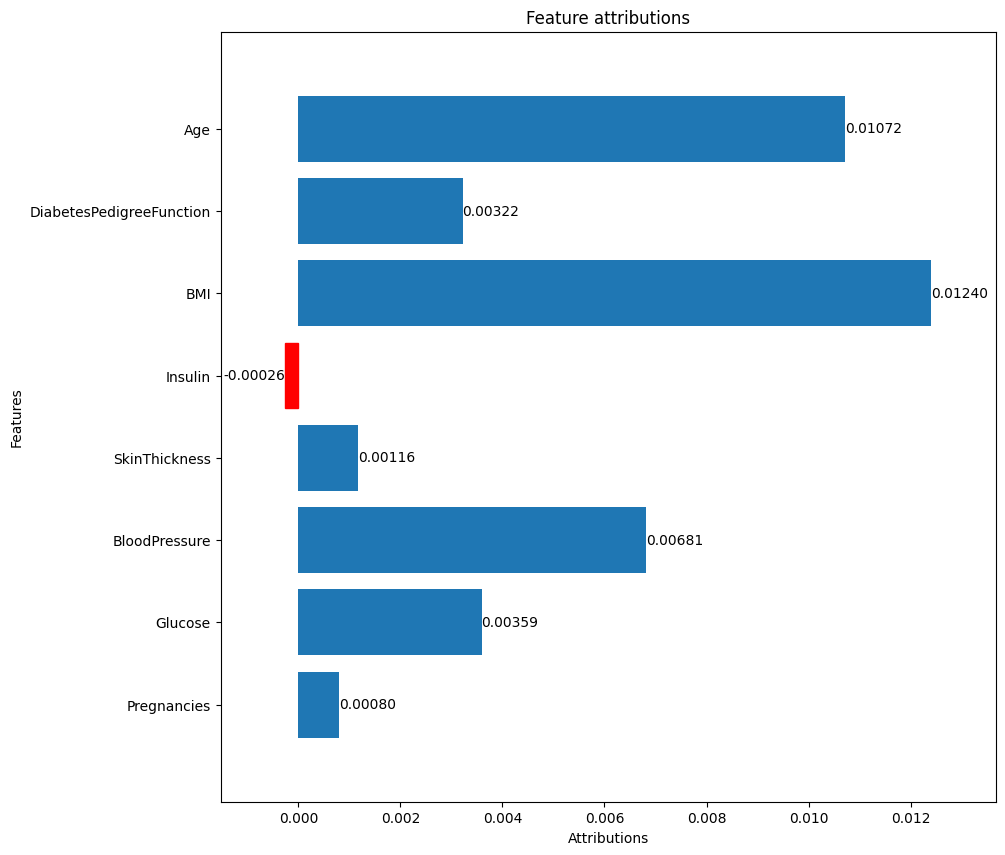

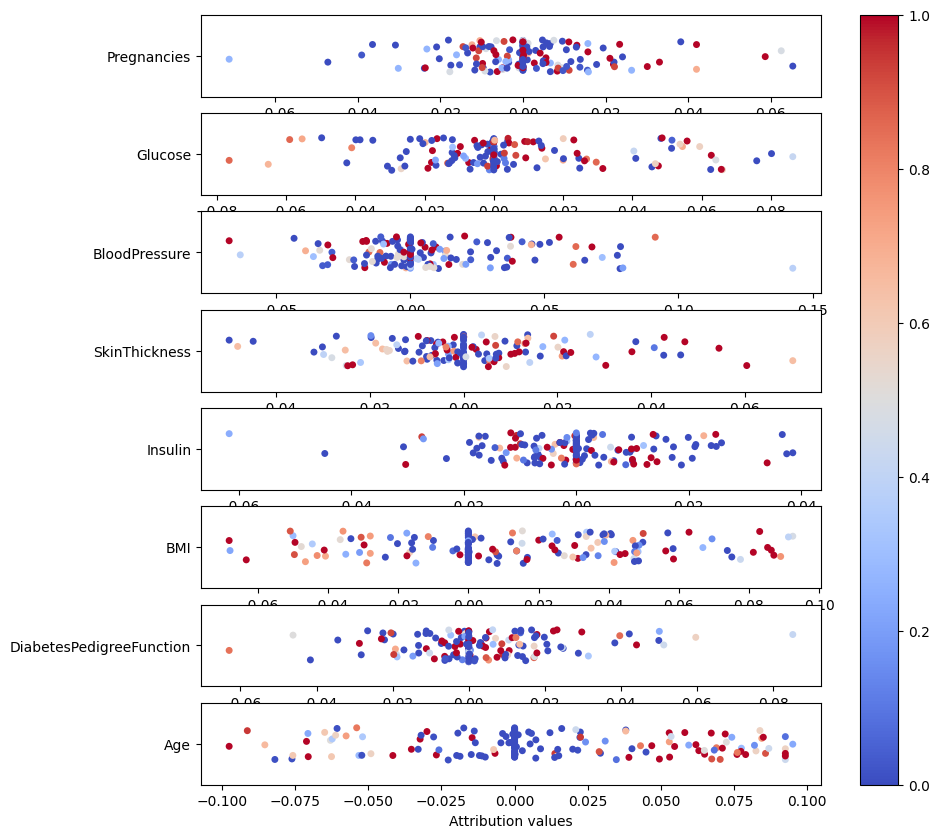

In [59]:
from beexai.explanation.plot_attr import bar_plot, plot_swarm, plot_waterfall
features_names = list(data_test.columns)
features_names.remove(target_col)
bar_plot(attributions, feature_names=features_names, mean=True)
plot_waterfall(attributions[0], feature_names=features_names, mean=False)
plot_swarm(X_test, attributions, feature_names=features_names)

In [55]:
### Train a NN model
NN_PARAMS = {"input_dim": X_train.shape[1], "output_dim": num_labels}

# trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device)
trainer = Trainer("XGBRegressor" ,task, device=device)
trainer.train(
    X_train.values,
    y_train.values,
    loss_file=f"../output/loss.png",
    x_val=X_val,
    y_val=y_val,
)
# trainer.model.eval()  # comment if not NN
metrics = trainer.get_metrics(X_test, y_test)
for k, v in metrics.items():
    print(f"{k}: {v}")

mse: 0.19821079124387622
rmse: 0.44520870526515566
mape: 1.3646592079756796
r2 score: -0.3674219785309065


In [57]:
TEST_SIZE = 100
X_test_sampled, y_test_sampled = stratified_sampling(X_test, y_test, TEST_SIZE, task)

METHOD = "KernelShap"  # Change to Non-Gradient based methods for sklearn models

exp = CaptumExplainer(
    trainer.model, task=task, method=METHOD, sklearn=True, device=device
)  # change sklearn to True if not NN
exp.init_explainer()

all_preds = all_preds = trainer.model.predict(X_test_sampled.values)
get_all_metrics(
    X_test_sampled,
    all_preds,
    trainer.model,
    exp,
    baseline="zero",
    auc_metric="mse", #change to mse for regression
    print_plot=False,
    save_path=None,
    device=device
)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


compute_faith_corr took 0.9876830577850342 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds = torch.tensor(self.std, device=self.device).float()


compute_inf took 1.4579393863677979 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = torch.tensor(self.radius, device=self.device)
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


compute_sens took 5.808813095092773 seconds
compute_comp took 0.06377291679382324 seconds
compute_suff took 0.0587763786315918 seconds
compute_mono took 0.2963407039642334 seconds
compute_auc took 0.2604825496673584 seconds
compute_complex took 0.0011382102966308594 seconds
compute_spar took 0.0006303787231445312 seconds


,FaithCorr,Infidelity,Sensitivity,Comprehensiveness,Sufficiency,Monotonicity,AUC_TP,Complexity,Sparseness
0,0.648923,0.379067,0.545882,0.38932,0.135841,0.428571,0.275876,0.205634,0.472053


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4ccedb8a90fdf36c83f3b09ffdb0b3e91b5da6d3f6b6607d7509f2797676b68b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built Lime


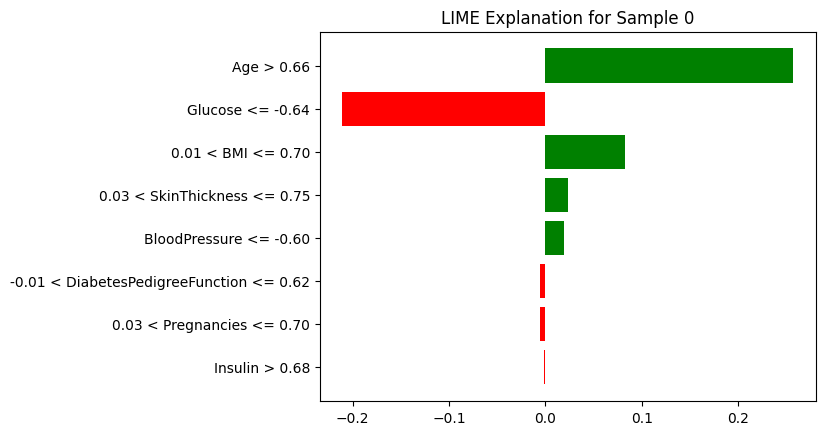

ExactExplainer explainer: 155it [00:21,  6.73it/s]                         


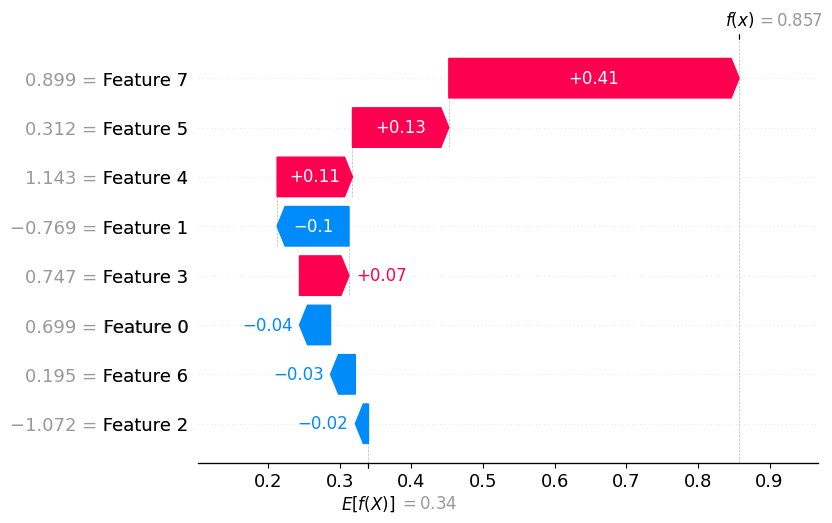

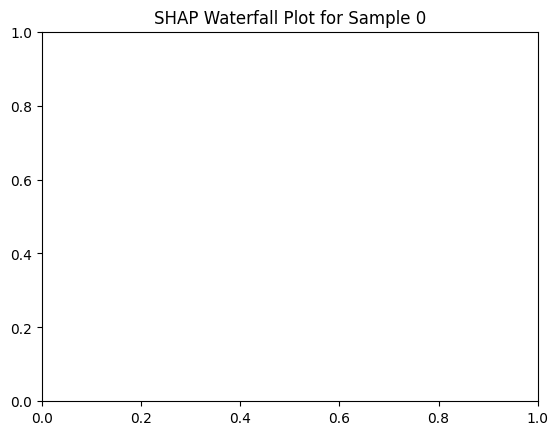

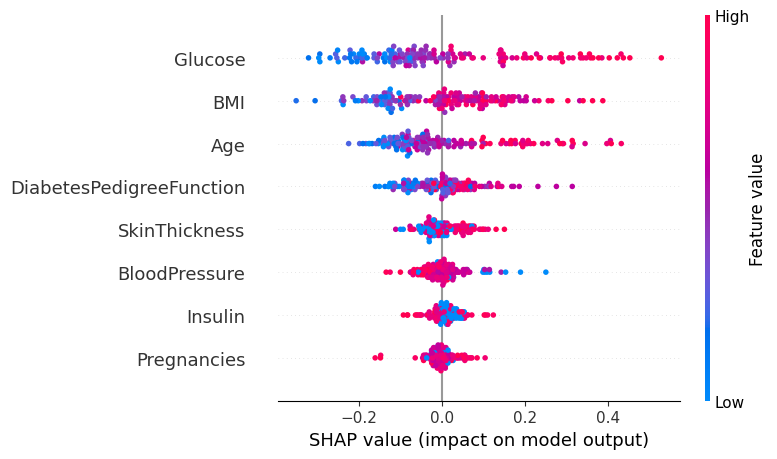

LIME and SHAP explanations saved to ./output/plots


In [62]:
!pip install Lime
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Assuming X_test, y_test, and trainer.model are already defined
# Convert X_test to numpy for compatibility with LIME and SHAP
X_test_np = X_test.values

# Define a sample to explain
sample_index = 0  # Change this to visualize different samples
sample = X_test_np[sample_index].reshape(1, -1)
sample_prediction = trainer.model.predict(sample)

# Plot directory
plot_dir = "./output/plots"
os.makedirs(plot_dir, exist_ok=True)

# LIME Explanation
lime_explainer = LimeTabularExplainer(
    X_train.values,  # Training data for LIME
    feature_names=X_test.columns.tolist(),
    class_names=["Prediction"],  # For regression, class name can be generic
    mode="regression" if task == "regression" else "classification"
)
lime_exp = lime_explainer.explain_instance(sample.flatten(), trainer.model.predict, num_features=10)

# Plot LIME Explanation
lime_plot_path = os.path.join(plot_dir, f"LIME_Explanation_Sample{sample_index}.png")
lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_index}")
plt.savefig(lime_plot_path)
plt.show()

# SHAP Explanation
shap_explainer = shap.Explainer(trainer.model.predict, X_train.values)  # SHAP initialization
shap_values = shap_explainer(X_test_np)  # Compute SHAP values

# Plot SHAP Explanation for the sample
shap_plot_path = os.path.join(plot_dir, f"SHAP_Explanation_Sample{sample_index}.png")
shap.waterfall_plot(shap_values[sample_index], max_display=10)
plt.title(f"SHAP Waterfall Plot for Sample {sample_index}")
plt.savefig(shap_plot_path)
plt.show()

# Summary Plot for SHAP (Feature Importance for the Test Dataset)
summary_plot_path = os.path.join(plot_dir, "SHAP_Summary_Plot.png")
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns, show=False)
plt.savefig(summary_plot_path)
plt.show()

print(f"LIME and SHAP explanations saved to {plot_dir}")